### Importamos librerias:
* Quitamos alertas de <i>Sklearn.</i>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings, joblib

from IPython.display import display, Markdown

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, precision_score, r2_score, recall_score, accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

warnings.filterwarnings('ignore'
                        , category = ConvergenceWarning
                        , module = 'sklearn')

### Funciones:

In [2]:
def markdown(txt):
    display(Markdown(txt))

In [3]:
def plot(df, col):
    df_temp = df.groupby([col], as_index = True).mean()['Survived'].sort_values(ascending = True)
    
    Grafico = df_temp.plot(kind = 'barh'
                       , width = 0.5
                       , color = plt.get_cmap('Blues')(np.linspace(start = 0.15
                                           , stop = 0.85
                                           , num = len(df_temp)))
                       , stacked = True
                       , legend = False
                       , fontsize = 10)
    
    Grafico.set_xlim([0, 0.85])
    Grafico.set_ylabel('')
    Grafico.grid(axis = 'x',alpha = 0.25)
    Grafico.set_xticklabels(['{:3.0f} %'.format(x * 100) for x in Grafico.get_xticks()])
    [spine.set_visible(False) for spine in Grafico.spines.values()]
    Grafico.spines['left'].set_visible(True)

    plt.tick_params(left = False, bottom = False)
    plt.title(col)
    df_temp = None 
    
def plot_Result(dfa):
    Grafico = dfa.plot(kind = 'barh'
                     , width = 0.7
                     , color = [plt.get_cmap('jet')(np.linspace(start = 0.9, stop = 0.2, num = len(dfa)))]
                     , stacked = True
                     , legend = False)

    Grafico.set_xlim([round(dfa.min()[0] / 2 - 1) * 2, round(dfa.max()[0] / 2 + 1) * 2])
    Grafico.set_ylabel('')
    Grafico.grid(axis = 'x',alpha = 0.25)
    Grafico.set_xticklabels(['{:3.0f} %'.format(x) for x in Grafico.get_xticks()])
    [spine.set_visible(False) for spine in Grafico.spines.values()]
    Grafico.spines['left'].set_visible(True)
    plt.tick_params(left = False, bottom = False)
    plt.title('Precisión (accuracy)')
    plt.show()
    plt.close()

In [4]:
def matriz(y, pred, Modelo = ''):
    mc = confusion_matrix(y, pred)
    Total = sum(np.transpose(mc))
    mcr = np.transpose(np.round(np.transpose(mc) / Total * 100,2))
    MC = pd.DataFrame(mc, columns=['No', 'Si'])

    MC['index'] = ['No', 'Si']
    MC['No'] *= -1

    Grafico = MC.set_index('index').sort_values(['index']
                                                , ascending=False).plot(kind = 'barh'
                                                                        , stacked = True
                                                                        , width = 0.75
                                                                        , color=[['#c9c9c9','#e60000'],['#00c800','#c9c9c9']]
                                                                        , legend = False
                                                                        , figsize = (3,1.2))
    
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    
    plt.gca().grid(axis='x',alpha=0)
    plt.gca().grid(axis='y',alpha=0)
    plt.gca().set_xlabel('{:.2f} % - '.format(np.mean(y == pred) * 100) + Modelo
                         , fontsize = 12
                         , alpha = 0.6)
    plt.gca().set_ylabel('')
    
    [spine.set_visible(False) for spine in plt.gca().spines.values()]
    
    plt.show()

### Importamos datos:
* Eliminamos columnas que contienen información con poco valor predictivo.
* Imputamos valores faltantantes en los campos <b>edad</b> (media del pasaje) y <b>puerto de embarque</b> (asignamos puerto mayoritario).

In [5]:
df = (pd.read_csv('Data/train.csv'
                  , sep = ','
                  , header = 0)
      .sample(frac = 1, random_state = 0))

df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Imputamos valores faltantes
* Obtenemos extraemos el título del nombre y calculamos las medias de edad para cada título.

In [6]:
df['Title'] = df.Name.str.extract('([A-Za-z]+)\.')

a = df.Title.value_counts().reset_index().transpose().to_numpy()
df.Title = df.Title.map(lambda x: x if x in a[0][a[1] > 10].tolist()else 'Others')

df.Title.value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Others     27
Name: Title, dtype: int64

* Imputamos valores faltantes en base a la media y el puerto de embarque mayoritario.

In [7]:
medias = df.groupby(['Title'], as_index = True).mean()['Age'].sort_values(ascending = True).to_dict()

df.fillna({'Age': df.Title.map(medias)
          , 'Embarked': df.Embarked.value_counts().index.tolist()[0]}, inplace = True)

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
495,496,0,3,"Yousseff, Mr. Gerious",male,32.368090,0,0,2627,14.4583,NaN,C,Mr
648,649,0,3,"Willey, Mr. Edward",male,32.368090,0,0,S.O./P.P. 751,7.5500,NaN,S,Mr
278,279,0,3,"Rice, Master. Eric",male,7.000000,4,1,382652,29.1250,NaN,Q,Master
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,35.898148,1,0,PC 17569,146.5208,B78,C,Mrs
255,256,1,3,"Touma, Mrs. Darwis (Hanne Youssef Razi)",female,29.000000,0,2,2650,15.2458,NaN,C,Mrs


### Gráfico de impacto por cada una de las variables:

### Mortalidad en función de cada variable

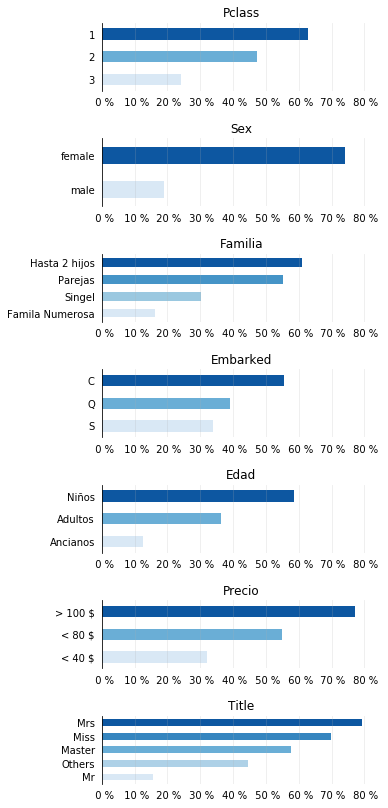

In [8]:
df['Edad'] = df.Age.map(lambda x: 'Niños' if x <= 15 else ('Adultos' if x <= 65 else 'Ancianos'))
df['Precio'] = df.Fare.map(lambda x: '< 40 $' if x <= 40 else ('< 80 $' if x <= 80 else '> 100 $'))
df['Familia'] = df['SibSp'] + df['Parch'] + 1
df.Familia = df.Familia.map(lambda x: 'Singel' if x == 1 else ('Parejas' if x == 2 else ('Famila Numerosa' if x >= 5 else 'Hasta 2 hijos')))

columnsList = ['Pclass', 'Sex', 'Familia', 'Embarked','Edad', 'Precio','Title']
markdown(f'### Mortalidad en función de cada variable')

Grafico = plt.figure(figsize =(5, 14)) 
Grafico.patch.set_facecolor('white')

plt.subplots_adjust(hspace = .7)

for i in range(1,len(columnsList) + 1):    
    plt.subplot(len(columnsList), 1, i)
    plot(df, columnsList[i -1])

plt.show()
plt.close()

df = df.drop(['PassengerId','Name','Cabin','SibSp','Parch','Edad','Precio', 'Familia'], axis='columns')

### Dividimos los datos entre Test y Train.

In [9]:
X = df.iloc[:, 1:]
y = df['Survived']

XE, XT, ye, yt = train_test_split(X
                                  , y
                                  , test_size = 0.4
                                  , random_state = 0)

### Configuración de modelos.
* Params con los distintos modelos que entrenamos.
* Configuración PipeLine con la conversión de variables categóricas y StandaeScaler.

In [10]:
Params = {'Random Forest': RandomForestClassifier(n_estimators = 250
                                                   , random_state = 0)
           , 'SGD': SGDClassifier(max_iter = 5
                                  , tol = None)
           , 'Perceptron': MLPClassifier(random_state = 0)
           , 'KNN': KNeighborsClassifier()
           , 'Tree Classifier': DecisionTreeClassifier(criterion = 'entropy'
                                                       , random_state = 0)
           , 'Estra Tree Classifier': ExtraTreesClassifier(random_state = 0)
           , 'GBC': GradientBoostingClassifier(random_state = 0)
           , 'SVC': SVC(kernel = 'linear'
                        , random_state = 0
                        , gamma = 'scale' )
           , 'Regresión logística': LogisticRegression(solver = 'lbfgs'
                                                       , multi_class = 'multinomial'
                                                       , class_weight = 'balanced'
                                                       , random_state = 0)}

Nums = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy = 'median')), 
        ('scaler' , StandardScaler())])

Text = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'missing')), 
        ('onehot' , OneHotEncoder(handle_unknown = 'ignore'))])

Pipe = ColumnTransformer(
    transformers = [
        ('num', Nums, X.select_dtypes(include = ['int64', 'float64']).columns), 
        ('cat', Text, X.select_dtypes(include = ['object']).columns)])

### Ejecutamos los modelos y guardamos resultados.
* Mostramos matriz de confusión del mejor resultado.
* Exportamos el modelo .pkl.

### Comparativa de los distintos modelos:

* Matríz de confusión:

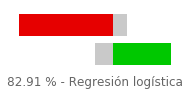

* Precisión modelos sobre base test:

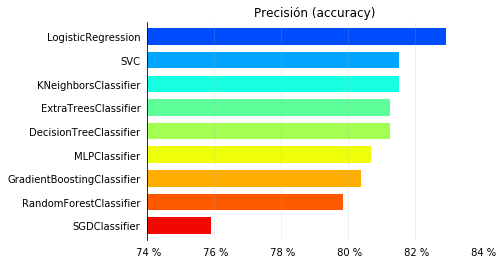

,Modelo,Tipo,Precisión (accuracy),Cross Val,Score (True),R Cuadrado,Recall
0,Regresión logística,LogisticRegression,82.91,0.841055,80.85,0.295972,"[0.87, 0.77]"
1,KNN,KNeighborsClassifier,81.51,0.818379,86.61,0.238265,"[0.93, 0.66]"
2,SVC,SVC,81.51,0.863522,81.06,0.238265,"[0.88, 0.72]"
3,Tree Classifier,DecisionTreeClassifier,81.23,0.810727,84.03,0.226723,"[0.91, 0.68]"
4,Estra Tree Classifier,ExtraTreesClassifier,81.23,0.85587,87.16,0.226723,"[0.93, 0.64]"
5,Perceptron,MLPClassifier,80.67,0.833333,77.62,0.20364,"[0.85, 0.75]"
6,GBC,GradientBoostingClassifier,80.39,0.827848,84.82,0.192099,"[0.92, 0.64]"
7,Random Forest,RandomForestClassifier,79.83,0.85028,85.85,0.169016,"[0.93, 0.61]"
8,SGD,SGDClassifier,75.91,0.816562,69.14,0.00743567,"[0.76, 0.76]"


In [11]:
Result, classifiersList = [{},[]]
kf = KFold(n_splits = 10)
           
markdown(f'### Comparativa de los distintos modelos:') 
           
for i in Params:
    Score, lista = [[],[]]
    clf = Pipeline(steps=[('Prepo', Pipe), 
                          ('Modelo', Params[i])])
    clf.fit(XE, ye)
    Score.append(Params[i].__class__.__name__)
    Score.append(round(np.mean(yt == clf.predict(XT)) * 100, 2))
    Score.append(cross_val_score(clf, XE, ye, cv=kf, scoring = 'accuracy').mean())
    Score.append(round(precision_score(yt, clf.predict(XT), labels = [0, 1], pos_label = 1) * 100, 2))
    Score.append(r2_score(yt, clf.predict(XT)))
    Score.append(recall_score(yt, clf.predict(XT), average = None).round(2))
    Result[i] = Score

    lista.append(i)
    lista.append(clf)
    classifiersList.append(tuple(lista))    

Result = (pd.DataFrame(Result, index=['Tipo'
                                      ,'Precisión (accuracy)'
                                      , 'Cross Val' 
                                      , 'Score (True)'
                                      , 'R Cuadrado'
                                      , 'Recall'])
          .transpose()
          .sort_values(by = 'Precisión (accuracy)'
                       , ascending = False)
          .reset_index()
          .rename(columns = {'index':'Modelo'}))

markdown(f'* Matríz de confusión:')

Best = Pipeline(steps=[('Prepo', Pipe),
                      ('Modelo', Params[Result['Modelo'][0]])])

Best.fit(XE, ye)

Grafico = matriz(yt, Best.predict(XT), Result['Modelo'][0])        

markdown(f'* Precisión modelos sobre base test:')
plot_Result(Result[['Tipo','Precisión (accuracy)']].set_index('Tipo').sort_values(by = 'Precisión (accuracy)'
                                                                          , ascending = True))
Result

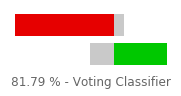

* Recall Voting Classifier:

array([0.91, 0.68])

In [12]:
from sklearn.ensemble import VotingClassifier

clf = VotingClassifier(classifiersList, n_jobs=-1)
clf.fit(XE, ye)
predictions = clf.predict(XT)

Grafico = matriz(yt, predictions, 'Voting Classifier')        
markdown(f'* Recall Voting Classifier:')

recall_score(yt, predictions, average = None).round(2)

* Importamos base test y aplicamos los cambios aplicados en el modelo.

In [13]:
df = (pd.read_csv('Data//test.csv'
                  , sep = ','
                  , header = 0))

df['Title'] = df.Name.str.extract('([A-Za-z]+)\.')
df.Title = df.Title.map(lambda x: x if x in a[0][a[1] > 10].tolist() else 'Others')

* Hacemos las predicciones sobre el nuevo dataframe que incorpora la base test con el clasificador Best ya que la media del resto de modelos está muy desbalaceada.

In [14]:
df['Survived'] = Best.predict(df[X.columns.tolist()])

* Exporto predicciones.

In [15]:
df[['PassengerId','Survived']].to_csv('submission.csv', index=False)